In [26]:
# Compares level 2 data with airplane location data
#
# Author: Brian Pitzel
# Date Created: 3 October 2024
# Date Modified: 7 November 2024

import numpy as np
import h5py 
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import csv
import glob
import pickle
import pymap3d as pm

%matplotlib widget


In [27]:
def find_aer_from_receiver(target_lat, target_lon, target_alt):
    """
    Finds the azimuth, elevation and range of a target or set of targets from the hard coded radar receiver
    Returns angles with respect to boresight, where negative is counter-clockwise from boresight
    """
    # receiver geodetic coordinates
    rx_lat = 52.243 # [deg]
    rx_lon = -106.450 # [deg]
    rx_alt = 0 # [m]
    az, el, slant_range = pm.geodetic2aer(target_lat, target_lon, target_alt,
                                    rx_lat, rx_lon, rx_alt,
                                    ell=pm.Ellipsoid.from_name("wgs84"), deg=True)

    return az, el, slant_range # [deg], [deg], [m] 

In [28]:
def map_target(rx, az, el, r):
    """
    Find the scatter location given tx location, rx location, total rf distance, and target angle-of-arrival
    using the 'WGS84' Earth model. Also determines the bistatic velocity vector and bistatic radar wavelength.

    Parameters
    ----------
        tx : float np.array
            [latitude, longitude, altitude] of tx array in degrees and kilometers
        rx : float np.array
            [latitude, longitude, altitude] of rx array in degrees and kilometers
        az : float np.array
            angle-of-arrival azimuth in degrees
        el : float np.array
            angle-of-arrival elevation in degrees
        rf : float np.array
            total rf path distance rf = c * tau in kilometers
        dop : float np.array
            doppler shift in hertz
        wavelength : float
            radar signal center wavelength

    Returns
    -------
        sx : float np.array
            [latitude, longitude, altitude] of scatter in degrees and kilometers


    Notes
    -----
    tx : transmitter location
    rx : receiver location
    sx : scatter location
    gx : geometric center of Earth, origin
    u_rt : unit vector rx to tx
    u_rs : unit vector rx to sx
    u_gt : unit vector gx to tx
    u_gr : unit vector gx to rx
    u_gs : unit vector gx to sx
    """

    # Initialize output arrays
    sx = np.zeros((3, len(r)), dtype=float)

    # Setup variables in correct units for pymap3d
    r = r * 1.0e3
    az = np.where(az < 0.0, az + 360.0, az)
    az = np.deg2rad(az)
    el = np.deg2rad(np.abs(el))

    # WGS84 Model for lat, long, alt
    sx[:, :] = pm.aer2geodetic(np.rad2deg(az), np.rad2deg(el), np.abs(r),
                               np.repeat(rx[0], len(az)),
                               np.repeat(rx[1], len(az)),
                               np.repeat(rx[2], len(az)),
                               ell=pm.Ellipsoid.from_name("wgs84"), deg=True)


    # Convert back to conventional units
    sx[2, :] /= 1.0e3
    return sx


In [29]:
az = np.load('allowed_airplane_azimuth.npy')
el = np.load('allowed_airplane_elevation.npy')
slant_range = np.load('allowed_airplane_slant_range.npy') / 1.0e3
rx = [52.24393, -106.45025, 0]

sx = map_target(rx, az.flatten(), el.flatten(), slant_range.flatten())

In [30]:
def retrieve_airplane_data(utc_time, time_filter, bounds):
    import traffic
    from traffic.data import opensky
    aircrafts_dbs = []
    
    airplane_start = utc_time[time_filter][0]
    for j in range(utc_time[time_filter].shape[0] - 1):
        this_timestamp = utc_time[time_filter][j]
        next_timestamp = utc_time[time_filter][j+1]
        if next_timestamp - this_timestamp >= datetime.timedelta(seconds=30): # if we are going to move onto another airplane
            airplane_end = this_timestamp
            #print(airplane_start, airplane_end)
            # get aircraft data for the airplane timeframe
            aircrafts_db = opensky.history(
                                airplane_start,
                                airplane_end,
                                bounds=bounds)
            aircrafts_dbs.append(aircrafts_db)

            airplane_start = next_timestamp

    return aircrafts_dbs

In [31]:
def load_airplane_data(filepath):
    file = open(filepath, 'rb')
    aircrafts_dbs = pickle.load(file)
    file.close()
    return aircrafts_dbs

In [32]:
SMALL_SIZE = 30 #38
MEDIUM_SIZE = 35 #42
BIGGER_SIZE = 50 #56

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
fig_width_inches = 17
fig_height_inches = 10

In [39]:
# get the level 2 files
y = 2021
m = 3
d = 13
n_days = 1 # how many days starting at and including d-day
level2_files = []
        #f'/mnt/NAS/airplane-data/L2-norelax/{y}/{m:02d}/{y}_{m:02d}_{(d+i):02d}/ib3d_normal_swht_{y}_{m:02d}_{(d+i):02d}_prelate_bakker.h5'
        #f'/mnt/NAS/airplane-data/L2-flip-heading-corr/{y}/{m:02d}/{y}_{m:02d}_{(d+i):02d}/ib3d_normal_swht_{y}_{m:02d}_{(d+i):02d}_prelate_bakker.h5'
        #f'/mnt/NAS/range-corrected-data/L2/{y}/{m:02d}/{y}_{m:02d}_{(d+i):02d}/ib3d_normal_swht_{y}_{m:02d}_{(d+i):02d}_prelate_bakker.h5'
for i in range(n_days):
    level2_files.append(f'/mnt/NAS/airplane-data/L2-narrow1/{y}/{m:02d}/{y}_{m:02d}_{(d+i):02d}/ib3d_normal_swht_{y}_{m:02d}_{(d+i):02d}_prelate_bakker.h5')
    level2_files.append(f'/mnt/NAS/airplane-data/L2-calibrated1/{y}/{m:02d}/{y}_{m:02d}_{(d+i):02d}/ib3d_normal_swht_{y}_{m:02d}_{(d+i):02d}_prelate_bakker.h5')
    #level2_files.append(f'/mnt/NAS/airplane-data/L2-recalibrated3_1/{y}/{m:02d}/{y}_{m:02d}_{(d+i):02d}/ib3d_normal_swht_{y}_{m:02d}_{(d+i):02d}_prelate_bakker.h5')
    #level2_files.append(f'/mnt/NAS/airplane-data/L2-antenna-calibrated_1/{y}/{m:02d}/{y}_{m:02d}_{(d+i):02d}/ib3d_normal_swht_{y}_{m:02d}_{(d+i):02d}_prelate_bakker.h5')
    #level2_files.append(f'/mnt/NAS/airplane-data/L2-median-calibrated_1/{y}/{m:02d}/{y}_{m:02d}_{(d+i):02d}/ib3d_normal_swht_{y}_{m:02d}_{(d+i):02d}_prelate_bakker.h5')
    #level2_files.append(f'/mnt/NAS/airplane-data/L2-low-stdev_1/{y}/{m:02d}/{y}_{m:02d}_{(d+i):02d}/ib3d_normal_swht_{y}_{m:02d}_{(d+i):02d}_prelate_bakker.h5')
    #level2_files.append(f'/mnt/NAS/airplane-data/L2-first-airplane_1/{y}/{m:02d}/{y}_{m:02d}_{(d+i):02d}/ib3d_normal_swht_{y}_{m:02d}_{(d+i):02d}_prelate_bakker.h5')
    #level2_files.append(f'/mnt/NAS/airplane-data/L2-new-coeffs_1/{y}/{m:02d}/{y}_{m:02d}_{(d+i):02d}/ib3d_normal_swht_{y}_{m:02d}_{(d+i):02d}_prelate_bakker.h5')
    #level2_files.append(f'/mnt/NAS/airplane-data/L2-new-coeffs-with-cal_1/{y}/{m:02d}/{y}_{m:02d}_{(d+i):02d}/ib3d_normal_swht_{y}_{m:02d}_{(d+i):02d}_prelate_bakker.h5')
    #level2_files.append(f'/mnt/NAS/airplane-data/L2-new-coeffs-with-cal-and-azimuth_1/{y}/{m:02d}/{y}_{m:02d}_{(d+i):02d}/ib3d_normal_swht_{y}_{m:02d}_{(d+i):02d}_prelate_bakker.h5')
    level2_files.append(f'/mnt/NAS/airplane-data/L2-new-coeffs-with-cal-and-pos-azimuth_1/{y}/{m:02d}/{y}_{m:02d}_{(d+i):02d}/ib3d_normal_swht_{y}_{m:02d}_{(d+i):02d}_prelate_bakker.h5')
    
    
#level2_files.append(f'/mnt/NAS/airplane-data/L2-highres/{y}/{m:02d}/{y}_{m:02d}_{d:02d}/ib3d_normal_swht_{y}_{m:02d}_{d:02d}_prelate_bakker.h5')
#level2_files.append(f'/mnt/NAS/airplane-data/L2-norelax/{y}/{m:02d}/{y}_{m:02d}_{d:02d}/ib3d_normal_swht_{y}_{m:02d}_{d:02d}_prelate_bakker.h5')
print(level2_files)
#level2_files = glob.glob(f'/mnt/NAS/airplane-data/L2/*/ib3d_normal_swht_20*.h5')
# descriptor for this run
descriptor = 'Corrected Ranges'

# set up vectorized timestamp converter
vutcfromtimestamp = np.vectorize(datetime.datetime.utcfromtimestamp)

# time interval of interest
t_start = [y,m,d,0,0,0]
t_end   = [y,m,d+n_days-1,14,59,59]

start_time = datetime.datetime(t_start[0], t_start[1], t_start[2], t_start[3], t_start[4], t_start[5])# - datetime.timedelta(hours=6)
end_time = datetime.datetime(t_end[0], t_end[1], t_end[2], t_end[3], t_end[4], t_end[5])# - datetime.timedelta(hours=6)

['/mnt/NAS/airplane-data/L2-narrow1/2021/03/2021_03_13/ib3d_normal_swht_2021_03_13_prelate_bakker.h5', '/mnt/NAS/airplane-data/L2-calibrated1/2021/03/2021_03_13/ib3d_normal_swht_2021_03_13_prelate_bakker.h5', '/mnt/NAS/airplane-data/L2-new-coeffs-with-cal-and-pos-azimuth_1/2021/03/2021_03_13/ib3d_normal_swht_2021_03_13_prelate_bakker.h5']


/tmp/ipykernel_951833/3573319633.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig_ll, ax_ll = plt.subplots()


/mnt/NAS/airplane-data/L2-narrow1/2021/03/2021_03_13/ib3d_normal_swht_2021_03_13_prelate_bakker.h5
(1214,)
/mnt/NAS/airplane-data/L2-calibrated1/2021/03/2021_03_13/ib3d_normal_swht_2021_03_13_prelate_bakker.h5
(2311,)
/mnt/NAS/airplane-data/L2-new-coeffs-with-cal-and-pos-azimuth_1/2021/03/2021_03_13/ib3d_normal_swht_2021_03_13_prelate_bakker.h5
(2341,)


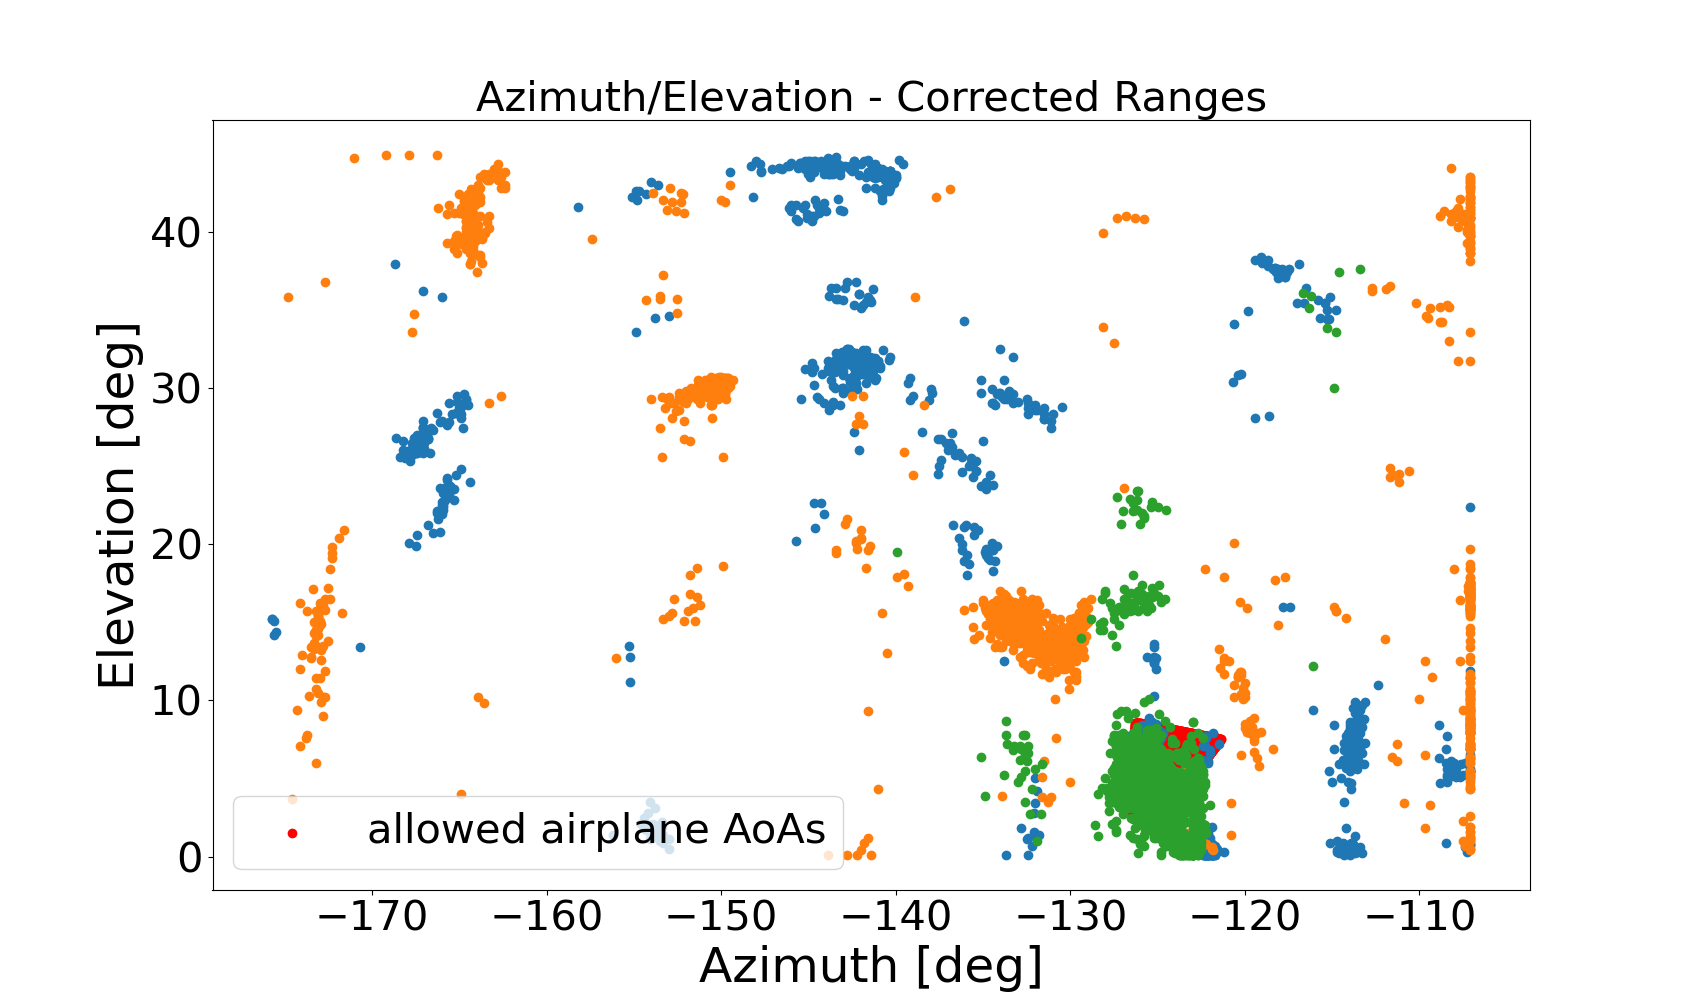

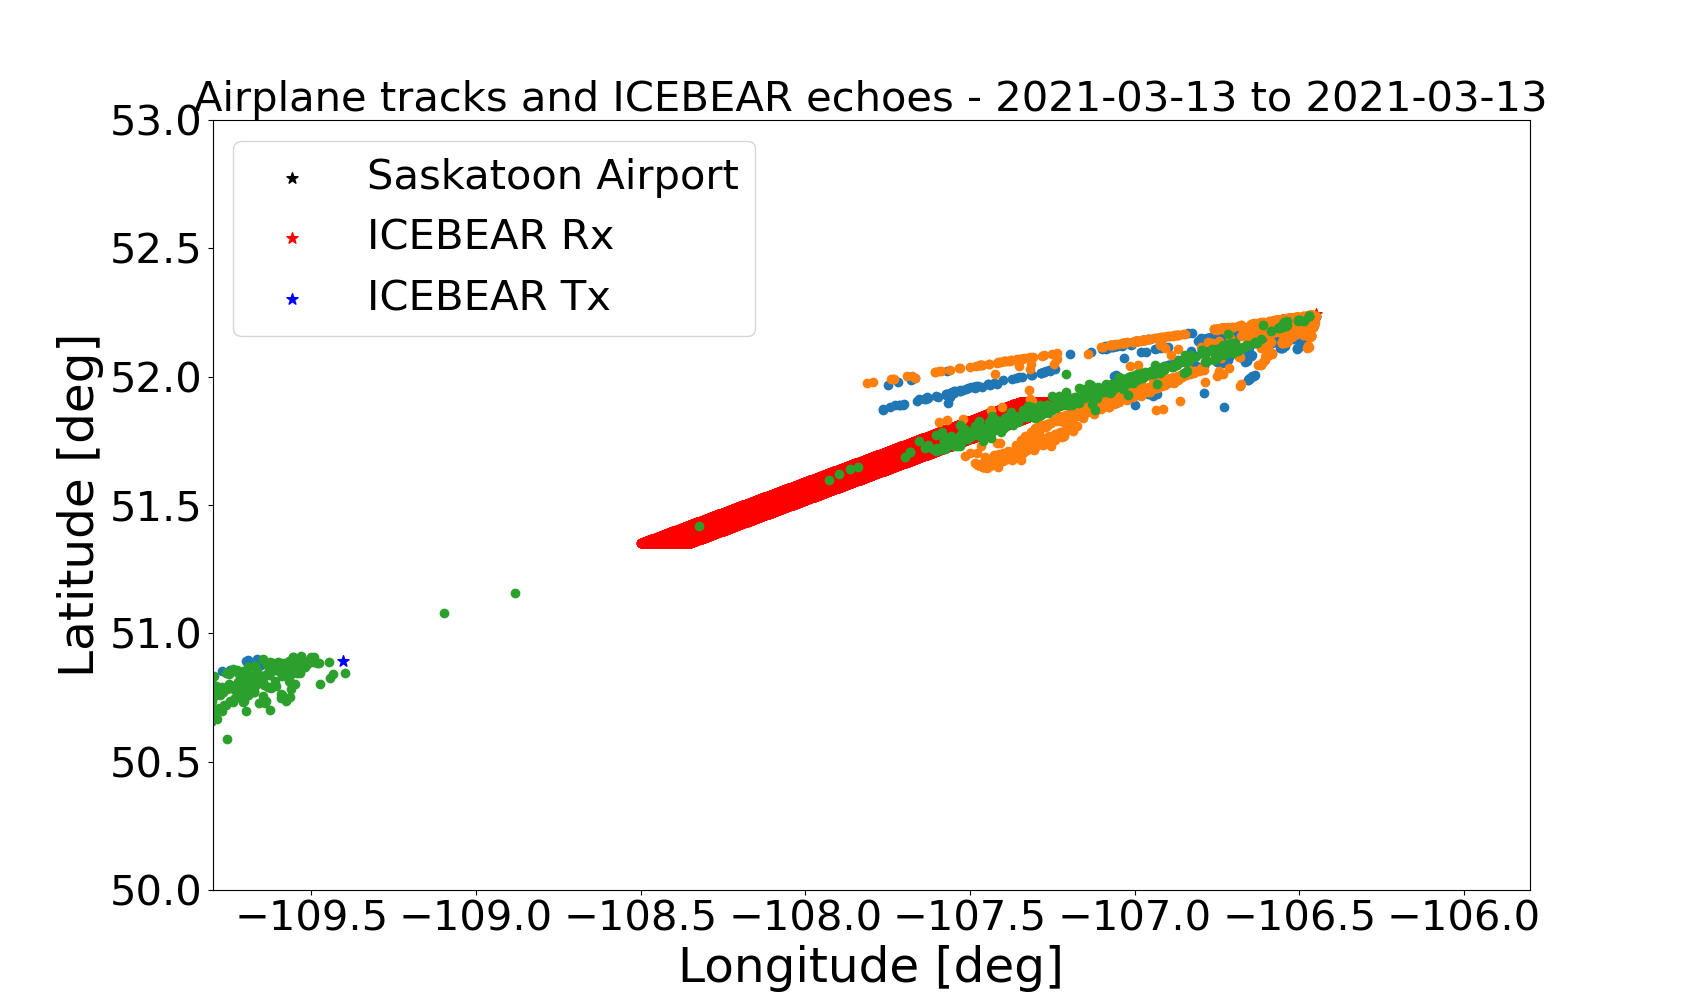

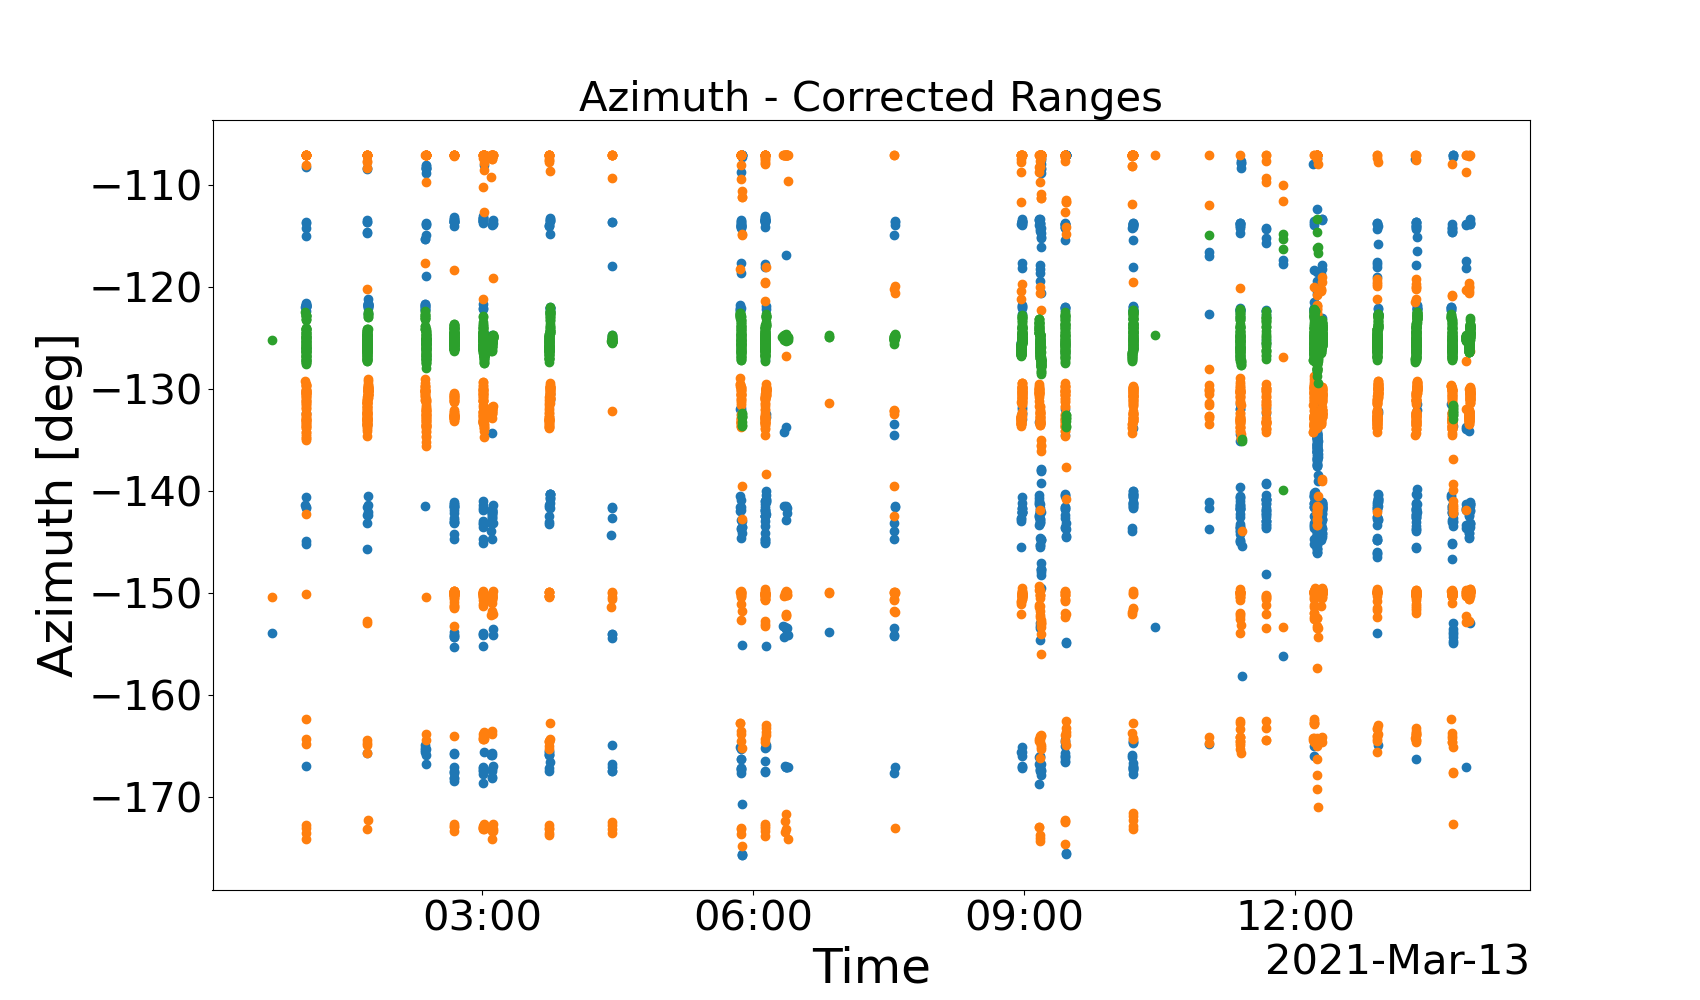

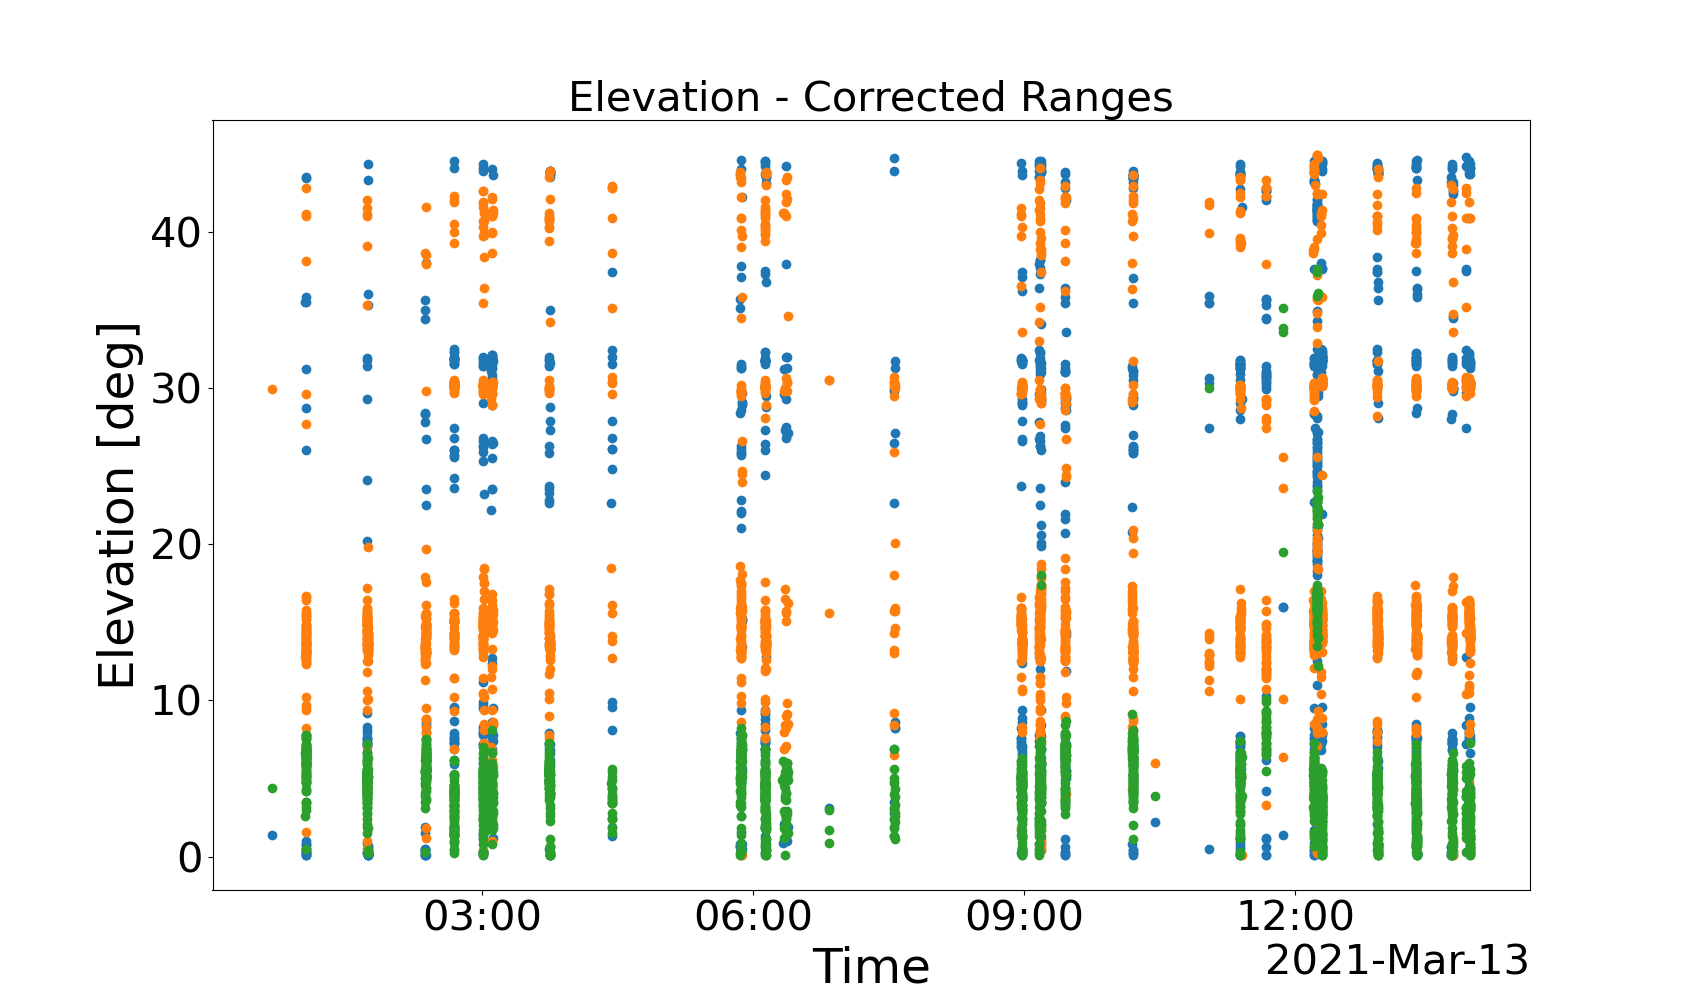

In [40]:
# set up axes
locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)

fig_ll, ax_ll = plt.subplots()
fig_ll.set_size_inches(fig_width_inches, fig_height_inches)
ax_ll.set_ylabel('Latitude [deg]')
ax_ll.set_xlabel('Longitude [deg]')
ax_ll.set_title(f'Airplane tracks and ICEBEAR echoes - {start_time.strftime("%Y-%m-%d")} to {end_time.strftime("%Y-%m-%d")}')
stoon_airport = [52.17145, -106.70039]
icebear_rx = [52.24393, -106.45025]
icebear_tx = [50.89335, -109.40317]
ax_ll.scatter(stoon_airport[1], stoon_airport[0], marker='*', c='black', s=70)
ax_ll.scatter(icebear_rx[1], icebear_rx[0], marker='*', c='r', s=70)
ax_ll.scatter(icebear_tx[1], icebear_tx[0], marker='*', c='b', s=70)
ax_ll.scatter(sx[1, :], sx[0, :], c='red')
ax_ll.set_xlim([-109.8, -105.8])
ax_ll.set_ylim([50, 53])
ax_ll.legend(['Saskatoon Airport','ICEBEAR Rx','ICEBEAR Tx'])

#fig_alt, ax_alt = plt.subplots()
#fig_alt.set_size_inches(fig_width_inches, fig_height_inches)
#ax_alt.set_ylabel('Altitude [km]')
#ax_alt.set_xlabel('Time')
#ax_alt.set_xlim([0, 15])
#ax_alt.set_title(f'Altitude - {descriptor}')
#ax_alt.xaxis.set_major_locator(locator)
#ax_alt.xaxis.set_major_formatter(formatter)

fig_az, ax_az = plt.subplots()
fig_az.set_size_inches(fig_width_inches, fig_height_inches)
ax_az.set_ylabel('Azimuth [deg]')
ax_az.set_xlabel('Time')
ax_az.set_title(f'Azimuth - {descriptor}')
ax_az.xaxis.set_major_locator(locator)
ax_az.xaxis.set_major_formatter(formatter)

fig_el, ax_el = plt.subplots()
fig_el.set_size_inches(fig_width_inches, fig_height_inches)
ax_el.set_ylabel('Elevation [deg]')
ax_el.set_xlabel('Time')
ax_el.set_title(f'Elevation - {descriptor}')
ax_el.xaxis.set_major_locator(locator)
ax_el.xaxis.set_major_formatter(formatter)

fig_azel, ax_azel = plt.subplots()
fig_azel.set_size_inches(fig_width_inches, fig_height_inches)
ax_azel.set_ylabel('Elevation [deg]')
ax_azel.set_xlabel('Azimuth [deg]')
ax_azel.set_title(f'Azimuth/Elevation - {descriptor}')
# plot the allowed az/el polygon (wrt boresight)
az = np.load('allowed_airplane_azimuth.npy')
az = np.where(az > 180.0, az - 360.0, az)
el = np.load('allowed_airplane_elevation.npy')
ax_azel.scatter(az, el, c='red')
ax_azel.legend(['allowed airplane AoAs'])

for file in level2_files:
    print(file)
    try:
        f = h5py.File(file)
    except Exception as e:
        print(f'Excepted {e}\nContinuing...')
        continue
    altitude = f['data']['altitude'][:]
    azimuth = f['data']['azimuth'][:]
    doppler_shift = f['data']['doppler_shift'][:]
    elevation = f['data']['elevation'][:]
    latitude = f['data']['latitude'][:]
    longitude = f['data']['longitude'][:]
    rf_distance = f['data']['rf_distance'][:]
    slant_range = f['data']['slant_range'][:]
    snr_db = f['data']['snr_db'][:]
    time = f['data']['time'][:]
    utc_time = vutcfromtimestamp(time)
    print(azimuth.shape)
    forbidden_days = [12, 14]
    if utc_time[0].day in forbidden_days:
        continue
    
    time_filter = (utc_time <= end_time) & (utc_time >= start_time) 
    #print(rf_distance[time_filter])
    #print(altitude[time_filter])
    range_filter = (rf_distance < 256) & (rf_distance > 246)
    time_filter = time_filter & range_filter

    # plot lat/lon
    ax_ll.scatter(longitude[time_filter], latitude[time_filter])
    
    # plot alt/time #NOTE: altitude is useless for airplane echoes because it depends on slant range, which is unattainable
    #ax_alt.scatter(utc_time[time_filter], altitude[time_filter])#, c=snr_db[time_filter])
    
    # plot az and el / time
    ax_az.scatter(utc_time[time_filter], azimuth[time_filter])
    ax_el.scatter(utc_time[time_filter], elevation[time_filter])
    
    # plot az/el
    ax_azel.scatter(azimuth[time_filter], elevation[time_filter])
    f.close()
plt.show()

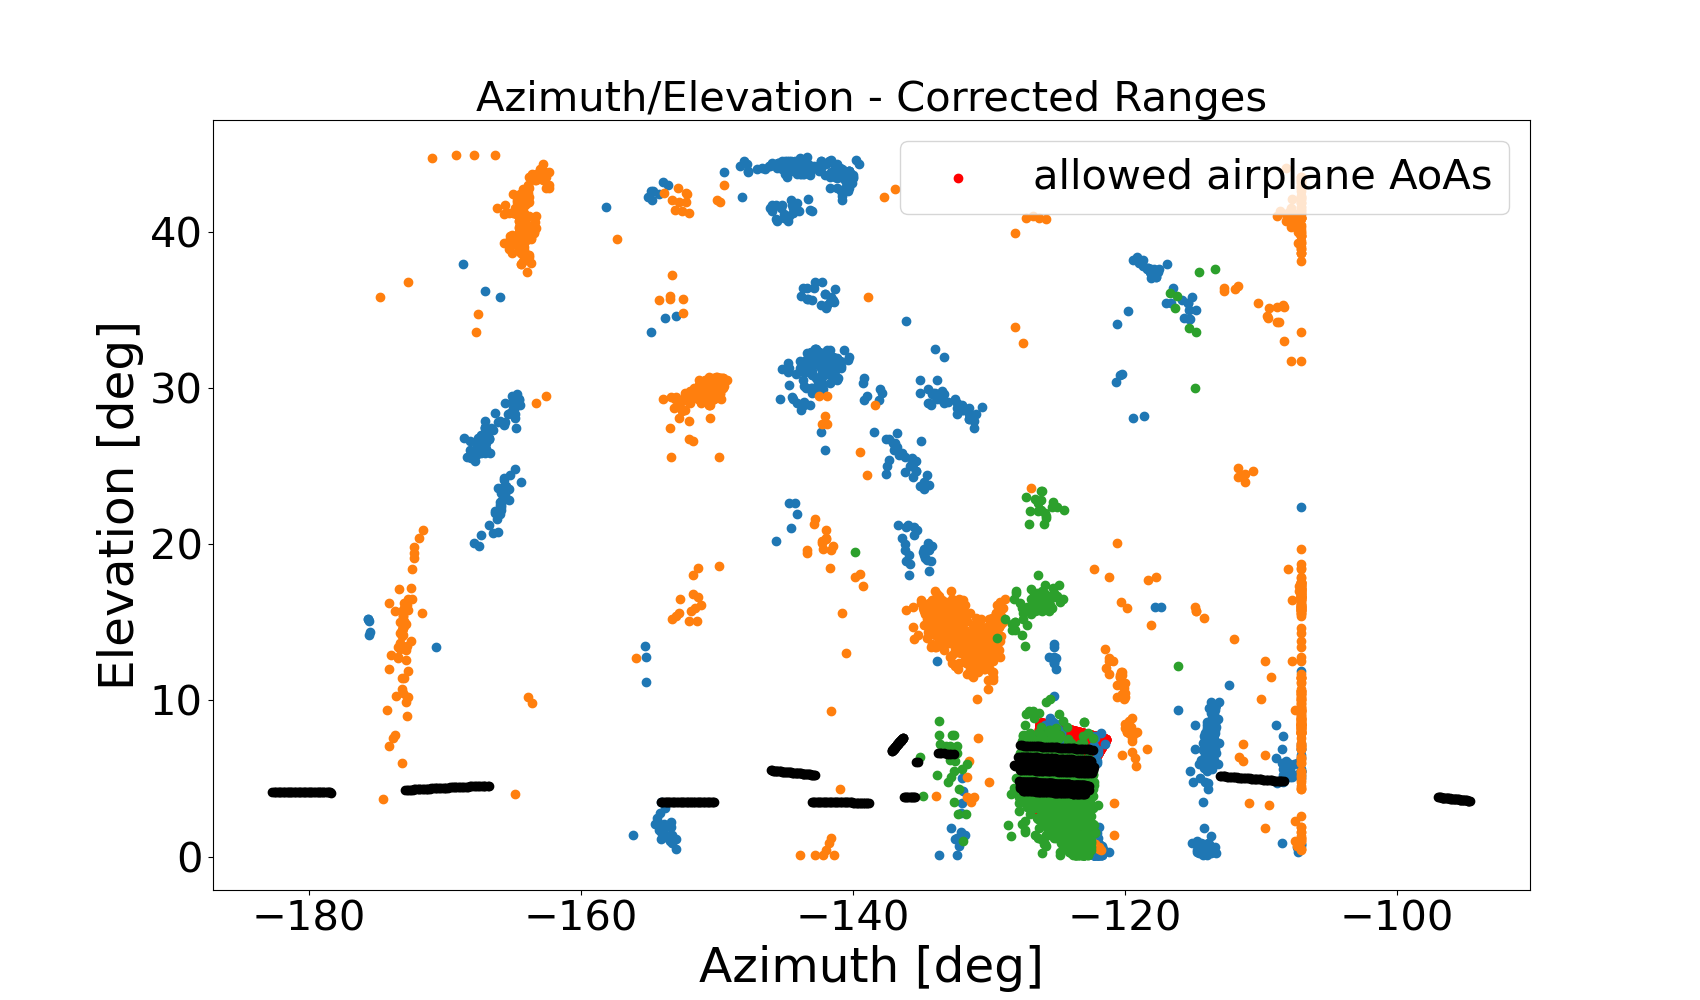

In [41]:
# aircraft tracks

lons = []
lats = []

# set aircraft boundaries if downloading the data
bounds = (-109.375, 50.771, -106.0, 52.765) # west, south, east, north

#aircrafts_dbs = load_airplane_data('/home/brian/airplane-process/airplane-code/aircrafts_dbs_2024-08-01_to_2024-08-15.pckl')
aircrafts_dbs = retrieve_airplane_data(utc_time, time_filter, bounds)

for db in aircrafts_dbs:
    # db is a database of every airplane in the timeframe.
    if db == None:
        continue
    
    # db[i].data.long/lat is the time series of data for one airplane (i)
    for i in range(len(db)): # db[i] is a single airplane in the timeframe.
        if len(db[i].data.timestamp) > 60:
            continue

        start_idx = db[i].data.index[0]
        end_idx = db[i].data.index[-1]
        ti = db[i].data.timestamp[start_idx]
        ti = ti.replace(tzinfo=None)
        tf = db[i].data.timestamp[end_idx]
        tf = tf.replace(tzinfo=None)

        if tf < start_time:
            continue
        if ti > end_time:
            break
        
        # find az/el from lat/long of airplane
        az, el, slant_range = find_aer_from_receiver(db[i].data.latitude, db[i].data.longitude, db[i].data.altitude / 3.281)
        #az = np.where(az > 180.0, az - 360.0, az)
        range_filter = (slant_range < 150e3) & (slant_range > 70e3)# & (az < -120)
        az = az[range_filter]
        el = el[range_filter]
        time = db[i].data.timestamp[range_filter]

        if(time.shape[0] == 0):
            continue
        
        # plot az vs time
        ax_az.scatter(time, az-360, c='black')
        ax_azel.scatter(az-360, el, c='black')

        az = -az + 90 # convert to wrt East angles

        ax_el.scatter(time, el, c='black')

        
        ax_ll.plot(db[i].data.longitude, db[i].data.latitude)
        #ax_alt.scatter(aircrafts_db[i].data.timestamp, aircrafts_db[i].data.altitude / 3.281 / 1000)
        lons.append(db[i].data.longitude)
        lats.append(db[i].data.latitude)


lons = np.hstack(lons)
lats = np.hstack(lats)

plt.show()

In [ ]:
fig_hist, ax_hist = plt.subplots()
fig_hist.set_size_inches(fig_width_inches, fig_height_inches)
ax_hist.set_ylabel('Latitude [deg]')
ax_hist.set_xlabel('Longitude [deg]')
ax_hist.set_title(f'Airplane track distribution - {start_time.strftime("%Y-%m-%d")} to {end_time.strftime("%Y-%m-%d")}')


x_edges = np.arange(-109.8, -105.8, 0.015)
y_edges = np.arange(50, 53, 0.015)

lons = np.hstack(lons)
lats = np.hstack(lats)
h = ax_hist.hist2d(lons, lats, bins=[x_edges, y_edges], range=[[-109.8, -105.8],[50, 53]], vmin=0, vmax=50)
c = plt.colorbar(h[3], ax=ax_hist, label='Count')
stoon_airport = [52.17145, -106.70039]
icebear_rx = [52.24393, -106.45025]
icebear_tx = [50.89335, -109.40317]
ax_hist.scatter(stoon_airport[1], stoon_airport[0], marker='*', c='black', s=70)
ax_hist.scatter(icebear_rx[1], icebear_rx[0], marker='*', c='r', s=70)
ax_hist.scatter(icebear_tx[1], icebear_tx[0], marker='*', c='b', s=70)
ax_hist.legend(['Saskatoon Airport','ICEBEAR Rx','ICEBEAR Tx'], loc='lower right', prop={'size': 15})

ax_hist.set_xlim([-109.8, -105.8])
ax_hist.set_ylim([50, 53])
plt.show()

In [ ]:
fig_hist, ax_hist = plt.subplots()
fig_hist.set_size_inches(fig_width_inches, fig_height_inches)
ax_hist.set_ylabel('Latitude [deg]')
ax_hist.set_xlabel('Longitude [deg]')
ax_hist.set_title(f'Lat and Lon - {start_time.strftime("%Y-%m-%d")}' )

extent = (-109.8, -105.8, 50, 53)

h = ax_hist.hexbin(lons, lats, extent=extent, gridsize=150, vmin=0, vmax=100)
c = plt.colorbar(h, ax=ax_hist, label='Count')
stoon_airport = [52.17145, -106.70039]
icebear_rx = [52.24393, -106.45025]
icebear_tx = [50.89335, -109.40317]
ax_hist.scatter(stoon_airport[1], stoon_airport[0], marker='*', c='black', s=70)
ax_hist.scatter(icebear_rx[1], icebear_rx[0], marker='*', c='r', s=70)
ax_hist.scatter(icebear_tx[1], icebear_tx[0], marker='*', c='b', s=70)
#ax_hist.legend(['Saskatoon Airport','ICEBEAR Rx','ICEBEAR Tx'], loc='lower right')

ax_hist.set_xlim([-109.8, -105.8])
ax_hist.set_ylim([50, 53])
plt.show()

In [ ]:
import pickle

# open a file, where you ant to store the data
file = open('aircrafts_dbs_2024-08-16_to_2024-08-31.pckl', 'wb')

# dump information to that file
pickle.dump(aircrafts_dbs, file)

# close the file
file.close()

In [ ]:

lons = []
lats = []

# file = open('aircrafts_dbs_2024-07-20_to_2024-07-31.pckl', 'rb')
# dbs = pickle.load(file)

# for db in dbs:
#     # db is a database of every airplane in the timeframe.
#     if db == None:
#         continue
    
#     # db[i].data.long/lat is the time series of data for one airplane (i)


#     for i in range(len(db)): # db[i] is a single airplane in the timeframe.
#         if len(db[i].data.timestamp) > 60:
#             continue
    
#         lons.append(db[i].data.longitude)
#         lats.append(db[i].data.latitude)

# file.close()

file = open('aircrafts_dbs_2024-08-01_to_2024-08-15.pckl', 'rb')
dbs = pickle.load(file)

for db in dbs:
    # db is a database of every airplane in the timeframe.
    if db == None:
        continue
    
    # db[i].data.long/lat is the time series of data for one airplane (i)


    for i in range(len(db)): # db[i] is a single airplane in the timeframe.
        if len(db[i].data.timestamp) > 60:
            continue
    
        lons.append(db[i].data.longitude)
        lats.append(db[i].data.latitude)


file.close()

file = open('aircrafts_dbs_2024-08-16_to_2024-08-31.pckl', 'rb')
dbs = pickle.load(file)

for db in dbs:
    # db is a database of every airplane in the timeframe.
    if db == None:
        continue
    
    # db[i].data.long/lat is the time series of data for one airplane (i)


    for i in range(len(db)): # db[i] is a single airplane in the timeframe.
        if len(db[i].data.timestamp) > 60:
            continue
    
        lons.append(db[i].data.longitude)
        lats.append(db[i].data.latitude)


file.close()


lons = np.hstack(lons)
lats = np.hstack(lats)

In [ ]:
fig_hist, ax_hist = plt.subplots()
fig_hist.set_size_inches(fig_width_inches, fig_height_inches)
ax_hist.set_ylabel('Latitude [deg]')
ax_hist.set_xlabel('Longitude [deg]')
ax_hist.set_title(f'Airplane track distribution - 2024-08-01 to {end_time.strftime("%Y-%m-%d")}')


x_edges = np.arange(-109.8, -105.8, 0.015)
y_edges = np.arange(50, 53, 0.015)

lons = np.hstack(lons)
lats = np.hstack(lats)
h = ax_hist.hist2d(lons, lats, bins=[x_edges, y_edges], range=[[-109.8, -105.8],[50, 53]], vmin=0, vmax=50, cmap='viridis')
c = plt.colorbar(h[3], ax=ax_hist, label='Count')
stoon_airport = [52.17145, -106.70039]
icebear_rx = [52.24393, -106.45025]
icebear_tx = [50.89335, -109.40317]
ax_hist.scatter(stoon_airport[1], stoon_airport[0], marker='*', c='black', s=150, edgecolor='white')
ax_hist.scatter(icebear_rx[1], icebear_rx[0], marker='*', c='r', s=150, edgecolor='white')
ax_hist.scatter(icebear_tx[1], icebear_tx[0], marker='*', c='b', s=150, edgecolor='white')
ax_hist.legend(['Saskatoon Airport','ICEBEAR Rx','ICEBEAR Tx'], loc='lower right', prop={'size': 15})

ax_hist.set_xlim([-109.8, -105.8])
ax_hist.set_ylim([50, 53])
plt.show()